In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import lightgbm as lgb
import optuna
import time
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Con este dataset extraeremos los datos de los incendios de 2017 para probar el modelo
bdif = pd.read_excel("bdif_modelo_2017.xlsx")
bdif.head()

,parte,año,cod_com,cod_prov,probignicion,detectadopor,fecha,combustible,fuego,lugar,...,velmedia,racha,sol,hrmedia,fwi,denpoblacion,denincendios,horario,areaquemada,claseincendio
0,1974020249,1974,11,2,0.0,otros,1974-04-25,bosques,sup_cop,otros,...,6.1,11.900000,9.5,56.0,12.101361,0.041339,0.000020,Tarde,8.0,incendio
1,1974020374,1974,11,2,0.0,otros,1974-05-19,bosques,sup_cop,excursionistas,...,6.4,13.100000,10.9,53.0,69.039001,0.334612,0.000013,Tarde,0.3,conato
2,1974020459,1974,11,46,0.0,agente_forestal,1974-06-11,bosques,sup_cop,otros,...,3.6,11.100000,3.3,71.0,11.837668,0.084859,0.000022,Mañana,0.6,conato
3,1974022274,1974,11,2,0.0,otros,1974-09-11,bosques,sup_cop,autovia_carretera,...,5.0,7.116667,8.9,63.0,42.358257,0.139880,0.000123,Tarde,2.0,incendio
4,1974022457,1974,11,2,0.0,agente_forestal,1974-10-01,mat_bos,sup_cop,otros,...,4.7,14.400000,9.3,45.0,15.454229,0.035034,0.000068,Mañana,0.5,conato


### Aplicamos mapeo de clases a la variable objetivo

In [3]:
mapeo_clases = {'conato': 0, 'incendio': 1, 'gif': 2}

# Aplicar el mapeo a la columna 'claseincendio'
bdif['claseincendio'] = bdif['claseincendio'].map(mapeo_clases)

# Verificar el resultado
bdif['claseincendio'].value_counts()

claseincendio
0    339190
1    237218
2      2008
Name: count, dtype: int64

In [4]:
# Separamos el dataset para usarlo para el entrenamiento del modelo
bdif_modelo = bdif[bdif['año'] <= 2016]
bdif_modelo.shape

(570372, 30)

### Preprocesamiento de los datos

In [5]:
# Seleccionamos las variables numéricas y categóricas 
numericas = ['probignicion', 'altitud', 'lon', 'lat', 'prec', 'tmax', 'dir', 'velmedia',
             'racha', 'sol', 'hrmedia', 'denpoblacion', 'denincendios', 'fwi']
categoricas = ['detectadopor', 'combustible', 'fuego', 'lugar', 'mes', 'dia', 'horario']

# Aplicamos las transformaciones para cada tipo de variable
prep = ColumnTransformer(transformers=[
        ('num', MinMaxScaler(), numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop=None, sparse_output=False), categoricas),])

# Creamos el pipeline
pipeline = Pipeline(steps=[('prep', prep)])

# Introducimos los datos de entrada
X = bdif_modelo.drop(columns=['claseincendio'])

# Ajustar el Pipeline a los datos y transformar
X_prep = pipeline.fit_transform(X)

# Lo pasamos a dataframe
X_prepdf = pd.DataFrame(X_prep, columns=pipeline.named_steps['prep'].get_feature_names_out())

# Hay que convertir las columnas categoricas a enteros
dummies = X_prepdf.filter(regex='^cat').columns
X_prepdf[dummies] = X_prepdf[dummies].astype(int)

# Eliminamos los prefijos
X_prepdf.columns = X_prepdf.columns.str.replace(r'^(num__|cat__)', '', regex=True)

# Mostrar el resultado
X_prepdf.head()

,probignicion,altitud,lon,lat,prec,tmax,dir,velmedia,racha,sol,...,mes_octubre,mes_septiembre,dia_festivo,dia_lab_vis_fes,dia_laborable,dia_sabado,horario_Madrugada,horario_Mañana,horario_Noche,horario_Tarde
0,0.0,0.517710,0.703490,0.663822,0.0,0.462795,0.805556,0.194268,0.218750,0.637584,...,0,0,0,0,1,0,0,0,0,1
1,0.0,0.335891,0.731106,0.672918,0.0,0.637024,0.500000,0.203822,0.240809,0.731544,...,0,0,1,0,0,0,0,0,0,1
2,0.0,0.351240,0.760152,0.707177,0.0,0.571688,0.250000,0.114650,0.204044,0.221477,...,0,0,0,0,1,0,0,1,0,0
3,0.0,0.664109,0.699029,0.672143,0.0,0.662432,0.418981,0.159236,0.130821,0.597315,...,0,1,0,0,1,0,0,0,0,1
4,0.0,0.410272,0.714636,0.675420,0.0,0.575318,0.694444,0.149682,0.264706,0.624161,...,1,0,0,0,1,0,0,1,0,0


In [6]:
# Reconstruimos el dataset
X_prepdf['claseincendio'] = bdif_modelo['claseincendio']
bdif_reconstruido = X_prepdf.copy()
bdif_reconstruido.head()

,probignicion,altitud,lon,lat,prec,tmax,dir,velmedia,racha,sol,...,mes_septiembre,dia_festivo,dia_lab_vis_fes,dia_laborable,dia_sabado,horario_Madrugada,horario_Mañana,horario_Noche,horario_Tarde,claseincendio
0,0.0,0.517710,0.703490,0.663822,0.0,0.462795,0.805556,0.194268,0.218750,0.637584,...,0,0,0,1,0,0,0,0,1,1
1,0.0,0.335891,0.731106,0.672918,0.0,0.637024,0.500000,0.203822,0.240809,0.731544,...,0,1,0,0,0,0,0,0,1,0
2,0.0,0.351240,0.760152,0.707177,0.0,0.571688,0.250000,0.114650,0.204044,0.221477,...,0,0,0,1,0,0,1,0,0,0
3,0.0,0.664109,0.699029,0.672143,0.0,0.662432,0.418981,0.159236,0.130821,0.597315,...,1,0,0,1,0,0,0,0,1,1
4,0.0,0.410272,0.714636,0.675420,0.0,0.575318,0.694444,0.149682,0.264706,0.624161,...,0,0,0,1,0,0,1,0,0,0


In [7]:
X = bdif_reconstruido[['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud',
          'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales',
          'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche',
          'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto',
          'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo',
          'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana']]
y = bdif_reconstruido['claseincendio']

In [8]:
# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Dataset submuestreado con ENN + Tomek Links

In [9]:
bdif_enn = pd.read_excel("bdif_submuestreado.xlsx")
bdif_enn.head()

,denincendios,tmax,denpoblacion,lon,lat,fuego_sup_cop,fwi,hrmedia,altitud,fuego_superficie,...,lugar_autovia_carretera,lugar_senda,detectadopor_otros,dia_festivo,mes_septiembre,combustible_pastizales,dia_sabado,combustible_bosques,horario_Mañana,claseincendio
0,0.014306,0.618875,0.000183,0.559100,0.802846,0,0.265486,0.572917,0.543093,1,...,0,0,0,0,0,1,0,0,0,0
1,0.000358,0.542650,0.000068,0.523174,0.647512,0,0.000000,0.656250,0.418536,1,...,0,1,1,0,0,1,1,0,0,0
2,0.000269,0.802178,0.000060,0.574670,0.718691,0,0.378725,0.427083,0.236128,1,...,0,0,0,0,0,0,0,0,0,0
3,0.000112,0.802178,0.000010,0.587270,0.722982,0,0.378725,0.427083,0.257379,1,...,0,0,0,0,0,0,0,0,0,0
4,0.000112,0.802178,0.000010,0.587270,0.722982,0,0.378725,0.427083,0.257379,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
print(bdif_enn['claseincendio'].value_counts())

claseincendio
0    70482
1    26177
2     1966
Name: count, dtype: int64


In [11]:
bdif_enn = bdif_enn[['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud',
          'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales',
          'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche',
          'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto',
          'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo',
          'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana', 'claseincendio']]

### Dataset submuestreado con ENN y reducción controlada de clases

In [12]:
X = bdif_enn.drop(['claseincendio'], axis=1)
y = bdif_enn['claseincendio']

rus = RandomUnderSampler(sampling_strategy={0:int(0.12*y.value_counts()[1]), 1:int(0.12*y.value_counts()[1])}, random_state=42)

X_res, y_res = rus.fit_resample(X, y)

bdif_sub = pd.concat([X_res, y_res], axis=1)
print(bdif_sub['claseincendio'].value_counts())

claseincendio
0    3141
1    3141
2    1966
Name: count, dtype: int64


### Sobremuestreo clase GIF con RandomOverSampler

In [13]:
X = bdif_sub.drop(['claseincendio'], axis=1)
y = bdif_sub['claseincendio']

X_train_sob, X_test, y_train_sob, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

random_oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train, y_train = random_oversampler.fit_resample(X_train_sob, y_train_sob)

print(f"Distribución de clases en el conjunto de entrenamiento después de Random Over-Sampling: {Counter(y_train)}")
print(f"Distribución de clases en el conjunto de test: {Counter(y_test)}")

Distribución de clases en el conjunto de entrenamiento después de Random Over-Sampling: Counter({1: 2513, 0: 2513, 2: 2513})
Distribución de clases en el conjunto de test: Counter({0: 629, 1: 628, 2: 393})


### Cálculos del modelo

In [14]:
# División en entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# Creamos el modelo
lgbm = lgb.LGBMClassifier(n_estimators=100, random_state=42)

# Entrenamos el modelo
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3404
[LightGBM] [Info] Number of data points in the train set: 7539, number of used features: 36
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier(random_state=42)

In [17]:
# Hacemos las predicciones
y_pred = lgbm.predict(X_test)

# Mostramos el informe
print(classification_report(y_test, y_pred, target_names=['conato', 'incendio', 'gif']))

              precision    recall  f1-score   support

      conato       0.94      0.93      0.94       629
    incendio       0.85      0.80      0.83       628
         gif       0.72      0.79      0.75       393

    accuracy                           0.85      1650
   macro avg       0.84      0.84      0.84      1650
weighted avg       0.85      0.85      0.85      1650



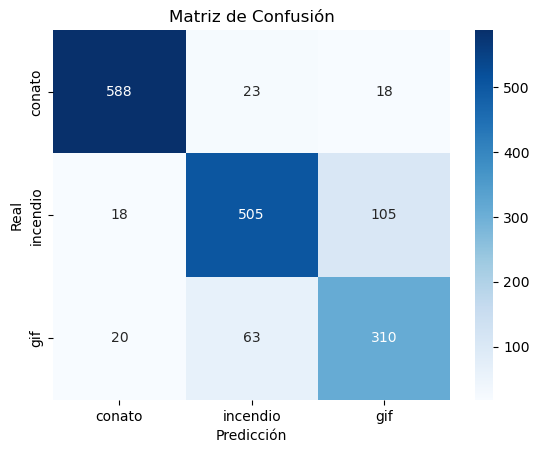

In [18]:
# Matriz de confusión con las clases ordenadas
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Guardamos las etiquetas reales
etiquetas= ['conato', 'incendio', 'gif']

# Creamos y mostramos la matriz mediante un mapa de calor
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

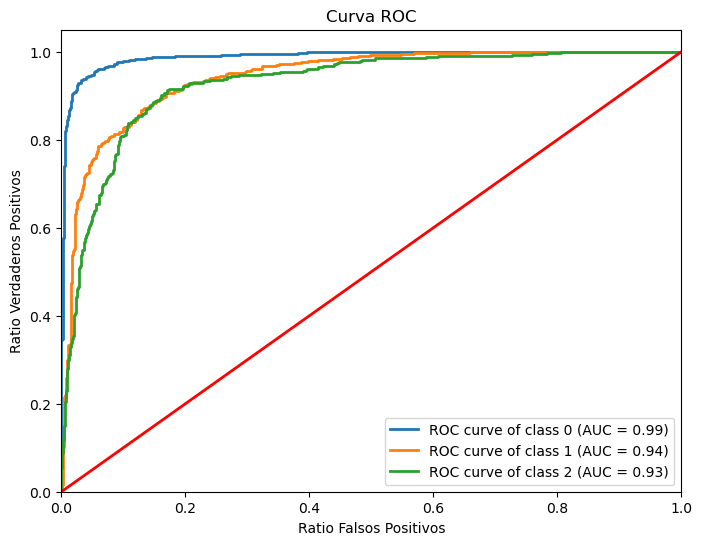

In [19]:
y_pred_prob = lgbm.predict_proba(X_test)

# Binarizamos porque es una clasificación multiclase
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Inicializamos las variables para calcular la curva roc y el auc
fpr = {}
tpr = {}
roc_auc = {}

# Dibujamos una curva ROC por cada clase y el calculo del auc
for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])  

# Dibujar las curvas 
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

# Creamos la diagonal
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='-')

# Configurar el gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio Falsos Positivos')
plt.ylabel('Ratio Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')

# Mostrar el gráfico
plt.show()

### Mejora con optuna

In [20]:
def objective(trial):
    param = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'n_estimators': 10000,
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 255),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'num_class': 3,
        'random_state': 42,
        'verbose': -1,
    }

    model = lgb.LGBMClassifier(**param)
    
    model.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50)])

    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds, average='macro')
    return f1

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=50)

[I 2024-12-29 14:19:35,573] A new study created in memory with name: no-name-59ace2ca-07bd-4e68-b761-2d983a112279


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10000]	valid_0's multi_logloss: 0.582238


[I 2024-12-29 14:19:42,649] Trial 0 finished with value: 0.7834309795009912 and parameters: {'learning_rate': 0.00030924270111493303, 'num_leaves': 89, 'max_depth': 2, 'min_child_samples': 95, 'subsample': 0.8850426960221294, 'colsample_bytree': 0.7130226009882425}. Best is trial 0 with value: 0.7834309795009912.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10000]	valid_0's multi_logloss: 0.581655


[I 2024-12-29 14:20:14,494] Trial 1 finished with value: 0.8101019631305726 and parameters: {'learning_rate': 0.0001153120815703766, 'num_leaves': 134, 'max_depth': 6, 'min_child_samples': 43, 'subsample': 0.7019807797236957, 'colsample_bytree': 0.8775538322644705}. Best is trial 1 with value: 0.8101019631305726.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7460]	valid_0's multi_logloss: 0.376306


[I 2024-12-29 14:20:36,280] Trial 2 finished with value: 0.8416914471529156 and parameters: {'learning_rate': 0.0014934696042727515, 'num_leaves': 233, 'max_depth': 7, 'min_child_samples': 59, 'subsample': 0.9840393647841938, 'colsample_bytree': 0.7926457973154757}. Best is trial 2 with value: 0.8416914471529156.


Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:20:38,389] Trial 3 finished with value: 0.8413984040928043 and parameters: {'learning_rate': 0.04118316821603004, 'num_leaves': 209, 'max_depth': -1, 'min_child_samples': 39, 'subsample': 0.8115002936586153, 'colsample_bytree': 0.7780200300461197}. Best is trial 2 with value: 0.8416914471529156.


Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.376982
Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:20:39,723] Trial 4 finished with value: 0.849130177901508 and parameters: {'learning_rate': 0.031017613934890886, 'num_leaves': 119, 'max_depth': 6, 'min_child_samples': 32, 'subsample': 0.7008463010272262, 'colsample_bytree': 0.8008328055586197}. Best is trial 4 with value: 0.849130177901508.


Early stopping, best iteration is:
[429]	valid_0's multi_logloss: 0.376753
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10000]	valid_0's multi_logloss: 0.564221


[I 2024-12-29 14:21:15,167] Trial 5 finished with value: 0.8235982053888907 and parameters: {'learning_rate': 0.00013011558689835875, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 64, 'subsample': 0.5825732360097104, 'colsample_bytree': 0.5876589895955653}. Best is trial 4 with value: 0.849130177901508.


Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:21:16,425] Trial 6 finished with value: 0.844219996224786 and parameters: {'learning_rate': 0.04553095465660084, 'num_leaves': 235, 'max_depth': 14, 'min_child_samples': 76, 'subsample': 0.6845645876663113, 'colsample_bytree': 0.6949923998729262}. Best is trial 4 with value: 0.849130177901508.


Early stopping, best iteration is:
[195]	valid_0's multi_logloss: 0.367262
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[864]	valid_0's multi_logloss: 0.37851


[I 2024-12-29 14:21:19,107] Trial 7 finished with value: 0.8416199920846853 and parameters: {'learning_rate': 0.014456552901550594, 'num_leaves': 194, 'max_depth': 7, 'min_child_samples': 98, 'subsample': 0.779068997798659, 'colsample_bytree': 0.9966329121873285}. Best is trial 4 with value: 0.849130177901508.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4894]	valid_0's multi_logloss: 0.433693


[I 2024-12-29 14:21:21,754] Trial 8 finished with value: 0.8213237594915972 and parameters: {'learning_rate': 0.027451038316670166, 'num_leaves': 150, 'max_depth': 1, 'min_child_samples': 77, 'subsample': 0.8189996057500103, 'colsample_bytree': 0.6051225361420435}. Best is trial 4 with value: 0.849130177901508.


Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:21:22,530] Trial 9 finished with value: 0.8384136616956962 and parameters: {'learning_rate': 0.0656158725347705, 'num_leaves': 114, 'max_depth': 8, 'min_child_samples': 61, 'subsample': 0.7132434282254672, 'colsample_bytree': 0.5478061938904853}. Best is trial 4 with value: 0.849130177901508.


Early stopping, best iteration is:
[224]	valid_0's multi_logloss: 0.364709
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2836]	valid_0's multi_logloss: 0.376102


[I 2024-12-29 14:21:31,678] Trial 10 finished with value: 0.8424680422192913 and parameters: {'learning_rate': 0.0035856847336244876, 'num_leaves': 32, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.504643709761218, 'colsample_bytree': 0.9271079544868392}. Best is trial 4 with value: 0.849130177901508.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10000]	valid_0's multi_logloss: 0.965346


[I 2024-12-29 14:24:01,064] Trial 11 finished with value: 0.8354901556741896 and parameters: {'learning_rate': 1.3978102250718018e-05, 'num_leaves': 254, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.6327288741812543, 'colsample_bytree': 0.6829242439831562}. Best is trial 4 with value: 0.849130177901508.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1166]	valid_0's multi_logloss: 0.367733


[I 2024-12-29 14:24:06,215] Trial 12 finished with value: 0.8473904684396384 and parameters: {'learning_rate': 0.007483482085915662, 'num_leaves': 171, 'max_depth': 11, 'min_child_samples': 79, 'subsample': 0.6341505845494173, 'colsample_bytree': 0.8375185701787002}. Best is trial 4 with value: 0.849130177901508.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1817]	valid_0's multi_logloss: 0.367737


[I 2024-12-29 14:24:13,226] Trial 13 finished with value: 0.8458213674988441 and parameters: {'learning_rate': 0.004833424276099171, 'num_leaves': 179, 'max_depth': 10, 'min_child_samples': 82, 'subsample': 0.5946630648215276, 'colsample_bytree': 0.8603614698288866}. Best is trial 4 with value: 0.849130177901508.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2061]	valid_0's multi_logloss: 0.385392


[I 2024-12-29 14:24:16,187] Trial 14 finished with value: 0.8384346382097921 and parameters: {'learning_rate': 0.009190489204063132, 'num_leaves': 162, 'max_depth': 4, 'min_child_samples': 42, 'subsample': 0.5293840969074475, 'colsample_bytree': 0.8344032211334825}. Best is trial 4 with value: 0.849130177901508.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5044]	valid_0's multi_logloss: 0.374856


[I 2024-12-29 14:24:44,274] Trial 15 finished with value: 0.8446003677469367 and parameters: {'learning_rate': 0.0013966743592992035, 'num_leaves': 118, 'max_depth': 10, 'min_child_samples': 50, 'subsample': 0.649088964112224, 'colsample_bytree': 0.9252831061025143}. Best is trial 4 with value: 0.849130177901508.


Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:24:45,031] Trial 16 finished with value: 0.8457101987905461 and parameters: {'learning_rate': 0.09430567460876113, 'num_leaves': 81, 'max_depth': 10, 'min_child_samples': 89, 'subsample': 0.7570896250025261, 'colsample_bytree': 0.7580663719069116}. Best is trial 4 with value: 0.849130177901508.


Early stopping, best iteration is:
[140]	valid_0's multi_logloss: 0.364516
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2487]	valid_0's multi_logloss: 0.386902


[I 2024-12-29 14:24:48,714] Trial 17 finished with value: 0.838380204696306 and parameters: {'learning_rate': 0.006864952097622385, 'num_leaves': 173, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.8644872344837877, 'colsample_bytree': 0.816456807728797}. Best is trial 4 with value: 0.849130177901508.


Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:24:50,248] Trial 18 finished with value: 0.847722107626859 and parameters: {'learning_rate': 0.020723845313927108, 'num_leaves': 51, 'max_depth': 11, 'min_child_samples': 71, 'subsample': 0.5825618423630996, 'colsample_bytree': 0.911074842265432}. Best is trial 4 with value: 0.849130177901508.


Early stopping, best iteration is:
[356]	valid_0's multi_logloss: 0.371748
Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:24:52,174] Trial 19 finished with value: 0.8446250173034319 and parameters: {'learning_rate': 0.020283353020988312, 'num_leaves': 52, 'max_depth': 15, 'min_child_samples': 67, 'subsample': 0.5684720060816393, 'colsample_bytree': 0.9980282797670067}. Best is trial 4 with value: 0.849130177901508.


Early stopping, best iteration is:
[415]	valid_0's multi_logloss: 0.376544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6815]	valid_0's multi_logloss: 0.380926


[I 2024-12-29 14:25:06,171] Trial 20 finished with value: 0.8404596131576021 and parameters: {'learning_rate': 0.0025191573234297185, 'num_leaves': 31, 'max_depth': 5, 'min_child_samples': 51, 'subsample': 0.5477996755243506, 'colsample_bytree': 0.9100313987970639}. Best is trial 4 with value: 0.849130177901508.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[651]	valid_0's multi_logloss: 0.368274


[I 2024-12-29 14:25:09,622] Trial 21 finished with value: 0.8430390301445237 and parameters: {'learning_rate': 0.012935441108027485, 'num_leaves': 105, 'max_depth': 12, 'min_child_samples': 71, 'subsample': 0.6205789696065661, 'colsample_bytree': 0.8780602153626368}. Best is trial 4 with value: 0.849130177901508.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10000]	valid_0's multi_logloss: 0.390184


[I 2024-12-29 14:25:58,877] Trial 22 finished with value: 0.8443429791096304 and parameters: {'learning_rate': 0.0004314034039200303, 'num_leaves': 143, 'max_depth': 12, 'min_child_samples': 86, 'subsample': 0.672034156685721, 'colsample_bytree': 0.9466545232616461}. Best is trial 4 with value: 0.849130177901508.


Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:26:00,372] Trial 23 finished with value: 0.8387929485814279 and parameters: {'learning_rate': 0.024470285308998096, 'num_leaves': 63, 'max_depth': 9, 'min_child_samples': 55, 'subsample': 0.7257326849874661, 'colsample_bytree': 0.7314080524671944}. Best is trial 4 with value: 0.849130177901508.


Early stopping, best iteration is:
[370]	valid_0's multi_logloss: 0.374791
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1241]	valid_0's multi_logloss: 0.368451


[I 2024-12-29 14:26:06,431] Trial 24 finished with value: 0.843803926664482 and parameters: {'learning_rate': 0.007124703569498998, 'num_leaves': 130, 'max_depth': 11, 'min_child_samples': 73, 'subsample': 0.6133594222806752, 'colsample_bytree': 0.8184795964304756}. Best is trial 4 with value: 0.849130177901508.


Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:26:07,052] Trial 25 finished with value: 0.8500165363793041 and parameters: {'learning_rate': 0.08788763355132749, 'num_leaves': 92, 'max_depth': 9, 'min_child_samples': 80, 'subsample': 0.663680298413851, 'colsample_bytree': 0.8505091911237441}. Best is trial 25 with value: 0.8500165363793041.


Early stopping, best iteration is:
[119]	valid_0's multi_logloss: 0.371645
Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:26:07,678] Trial 26 finished with value: 0.8399742093755306 and parameters: {'learning_rate': 0.09566228924793395, 'num_leaves': 92, 'max_depth': 8, 'min_child_samples': 33, 'subsample': 0.6662442882791112, 'colsample_bytree': 0.9617688922616219}. Best is trial 25 with value: 0.8500165363793041.


Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.382069
Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:26:08,456] Trial 27 finished with value: 0.8427901176493106 and parameters: {'learning_rate': 0.048540334717922774, 'num_leaves': 53, 'max_depth': 5, 'min_child_samples': 90, 'subsample': 0.737849913164992, 'colsample_bytree': 0.6469243005377725}. Best is trial 25 with value: 0.8500165363793041.


Early stopping, best iteration is:
[428]	valid_0's multi_logloss: 0.374132
Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:26:09,848] Trial 28 finished with value: 0.8461237283025541 and parameters: {'learning_rate': 0.030007122114318704, 'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.7747801403321284, 'colsample_bytree': 0.8795140327984371}. Best is trial 25 with value: 0.8500165363793041.


Early stopping, best iteration is:
[268]	valid_0's multi_logloss: 0.373338
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10000]	valid_0's multi_logloss: 0.490241


[I 2024-12-29 14:26:23,231] Trial 29 finished with value: 0.8119284224164276 and parameters: {'learning_rate': 0.00038934866916779873, 'num_leaves': 101, 'max_depth': 3, 'min_child_samples': 94, 'subsample': 0.9120124769524783, 'colsample_bytree': 0.7835203996314369}. Best is trial 25 with value: 0.8500165363793041.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10000]	valid_0's multi_logloss: 1.05892


[I 2024-12-29 14:26:28,185] Trial 30 finished with value: 0.6330405404014451 and parameters: {'learning_rate': 1.0388117494411115e-05, 'num_leaves': 90, 'max_depth': 1, 'min_child_samples': 86, 'subsample': 0.562020674442044, 'colsample_bytree': 0.7374141651796224}. Best is trial 25 with value: 0.8500165363793041.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[680]	valid_0's multi_logloss: 0.366153


[I 2024-12-29 14:26:31,145] Trial 31 finished with value: 0.8467834717834718 and parameters: {'learning_rate': 0.014139127482726948, 'num_leaves': 119, 'max_depth': 11, 'min_child_samples': 79, 'subsample': 0.6413273816037046, 'colsample_bytree': 0.8457568534500961}. Best is trial 25 with value: 0.8500165363793041.


Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:26:31,912] Trial 32 finished with value: 0.8414402672638189 and parameters: {'learning_rate': 0.0628575317475971, 'num_leaves': 155, 'max_depth': 9, 'min_child_samples': 80, 'subsample': 0.7001323352124003, 'colsample_bytree': 0.8884932957246976}. Best is trial 25 with value: 0.8500165363793041.


Early stopping, best iteration is:
[149]	valid_0's multi_logloss: 0.37102
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10000]	valid_0's multi_logloss: 0.366594


[I 2024-12-29 14:27:19,363] Trial 33 finished with value: 0.8441884733224329 and parameters: {'learning_rate': 0.0007702821083359912, 'num_leaves': 131, 'max_depth': 13, 'min_child_samples': 74, 'subsample': 0.6670831439848339, 'colsample_bytree': 0.8091420820468271}. Best is trial 25 with value: 0.8500165363793041.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5407]	valid_0's multi_logloss: 0.378658


[I 2024-12-29 14:27:31,452] Trial 34 finished with value: 0.8467165220204457 and parameters: {'learning_rate': 0.002416502882818969, 'num_leaves': 50, 'max_depth': 6, 'min_child_samples': 65, 'subsample': 0.5923386905236493, 'colsample_bytree': 0.8477789161500376}. Best is trial 25 with value: 0.8500165363793041.


Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:27:32,471] Trial 35 finished with value: 0.8423080908884036 and parameters: {'learning_rate': 0.03365390872263783, 'num_leaves': 202, 'max_depth': 8, 'min_child_samples': 83, 'subsample': 0.6165766106669617, 'colsample_bytree': 0.9080379709439528}. Best is trial 25 with value: 0.8500165363793041.


Early stopping, best iteration is:
[283]	valid_0's multi_logloss: 0.370302
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[455]	valid_0's multi_logloss: 0.370456


[I 2024-12-29 14:27:35,000] Trial 36 finished with value: 0.8467318180386839 and parameters: {'learning_rate': 0.016624848387311826, 'num_leaves': 181, 'max_depth': 11, 'min_child_samples': 58, 'subsample': 0.7040474362115522, 'colsample_bytree': 0.7948095675714744}. Best is trial 25 with value: 0.8500165363793041.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10000]	valid_0's multi_logloss: 0.850653


[I 2024-12-29 14:28:06,694] Trial 37 finished with value: 0.806602052191364 and parameters: {'learning_rate': 3.289214385792573e-05, 'num_leaves': 101, 'max_depth': 6, 'min_child_samples': 36, 'subsample': 0.5025607163046264, 'colsample_bytree': 0.7709714180551791}. Best is trial 25 with value: 0.8500165363793041.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[593]	valid_0's multi_logloss: 0.370818


[I 2024-12-29 14:28:11,152] Trial 38 finished with value: 0.8484395830134277 and parameters: {'learning_rate': 0.010206803445849358, 'num_leaves': 219, 'max_depth': 13, 'min_child_samples': 46, 'subsample': 0.9864611423679378, 'colsample_bytree': 0.8629620194950589}. Best is trial 25 with value: 0.8500165363793041.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10000]	valid_0's multi_logloss: 0.545324


[I 2024-12-29 14:29:31,124] Trial 39 finished with value: 0.818815993365872 and parameters: {'learning_rate': 0.00012277706046308348, 'num_leaves': 230, 'max_depth': 13, 'min_child_samples': 46, 'subsample': 0.9972250866798198, 'colsample_bytree': 0.9734606997375084}. Best is trial 25 with value: 0.8500165363793041.


Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:29:32,852] Trial 40 finished with value: 0.8473538860629831 and parameters: {'learning_rate': 0.04758209568847016, 'num_leaves': 217, 'max_depth': 15, 'min_child_samples': 28, 'subsample': 0.9521623938216526, 'colsample_bytree': 0.5027290661680679}. Best is trial 25 with value: 0.8500165363793041.


Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.366142
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[547]	valid_0's multi_logloss: 0.372703


[I 2024-12-29 14:29:37,734] Trial 41 finished with value: 0.8460452394300836 and parameters: {'learning_rate': 0.010794894235302936, 'num_leaves': 255, 'max_depth': 13, 'min_child_samples': 40, 'subsample': 0.8073334841236526, 'colsample_bytree': 0.8592370571085635}. Best is trial 25 with value: 0.8500165363793041.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1348]	valid_0's multi_logloss: 0.37252


[I 2024-12-29 14:29:46,126] Trial 42 finished with value: 0.8477075627943608 and parameters: {'learning_rate': 0.005039911231418175, 'num_leaves': 189, 'max_depth': 14, 'min_child_samples': 61, 'subsample': 0.6809015068781743, 'colsample_bytree': 0.8971889837324243}. Best is trial 25 with value: 0.8500165363793041.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1540]	valid_0's multi_logloss: 0.370231


[I 2024-12-29 14:29:55,881] Trial 43 finished with value: 0.8495401414043978 and parameters: {'learning_rate': 0.004377611527407171, 'num_leaves': 198, 'max_depth': 14, 'min_child_samples': 60, 'subsample': 0.6921399516559334, 'colsample_bytree': 0.8991412884248348}. Best is trial 25 with value: 0.8500165363793041.


Training until validation scores don't improve for 50 rounds


[I 2024-12-29 14:29:58,267] Trial 44 finished with value: 0.8529399715822682 and parameters: {'learning_rate': 0.02184757982797271, 'num_leaves': 222, 'max_depth': 14, 'min_child_samples': 52, 'subsample': 0.8444314425151311, 'colsample_bytree': 0.9294851722869432}. Best is trial 44 with value: 0.8529399715822682.


Early stopping, best iteration is:
[283]	valid_0's multi_logloss: 0.370911
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1919]	valid_0's multi_logloss: 0.376327


[I 2024-12-29 14:30:14,122] Trial 45 finished with value: 0.8502246889141953 and parameters: {'learning_rate': 0.0031989684448164805, 'num_leaves': 219, 'max_depth': 15, 'min_child_samples': 48, 'subsample': 0.8592438877285249, 'colsample_bytree': 0.9493314382868507}. Best is trial 44 with value: 0.8529399715822682.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2233]	valid_0's multi_logloss: 0.375001


[I 2024-12-29 14:30:29,467] Trial 46 finished with value: 0.8507777785892889 and parameters: {'learning_rate': 0.0029390123918052492, 'num_leaves': 236, 'max_depth': 15, 'min_child_samples': 54, 'subsample': 0.8643363490487924, 'colsample_bytree': 0.9527757519591853}. Best is trial 44 with value: 0.8529399715822682.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3202]	valid_0's multi_logloss: 0.372662


[I 2024-12-29 14:30:51,356] Trial 47 finished with value: 0.8494874839494845 and parameters: {'learning_rate': 0.00201596712333218, 'num_leaves': 228, 'max_depth': 15, 'min_child_samples': 54, 'subsample': 0.8490823949940783, 'colsample_bytree': 0.9515754938076566}. Best is trial 44 with value: 0.8529399715822682.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5128]	valid_0's multi_logloss: 0.379961


[I 2024-12-29 14:31:30,742] Trial 48 finished with value: 0.8384877762935612 and parameters: {'learning_rate': 0.0010964724978167824, 'num_leaves': 246, 'max_depth': 14, 'min_child_samples': 47, 'subsample': 0.9106831815637936, 'colsample_bytree': 0.9740579479454899}. Best is trial 44 with value: 0.8529399715822682.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8789]	valid_0's multi_logloss: 0.373994


[I 2024-12-29 14:32:33,946] Trial 49 finished with value: 0.8473569836659635 and parameters: {'learning_rate': 0.000695529232454341, 'num_leaves': 209, 'max_depth': 15, 'min_child_samples': 55, 'subsample': 0.8358730592758791, 'colsample_bytree': 0.9366839194727923}. Best is trial 44 with value: 0.8529399715822682.


In [21]:
# Mostrar los mejores resultados
print(f"Mejor valor objetivo: {study.best_value}")
print(f"Mejores hiperparámetros: {study.best_params}")

# Entrenar el modelo con el mejor
best_model = lgb.LGBMClassifier(**study.best_params)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Mejor valor objetivo: 0.8529399715822682
Mejores hiperparámetros: {'learning_rate': 0.02184757982797271, 'num_leaves': 222, 'max_depth': 14, 'min_child_samples': 52, 'subsample': 0.8444314425151311, 'colsample_bytree': 0.9294851722869432}
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       629
           1       0.87      0.80      0.83       628
           2       0.73      0.81      0.77       393

    accuracy                           0.85      1650
   macro avg       0.84      0.85      0.84      1650
weighted avg       0.86      0.85      0.85      1650



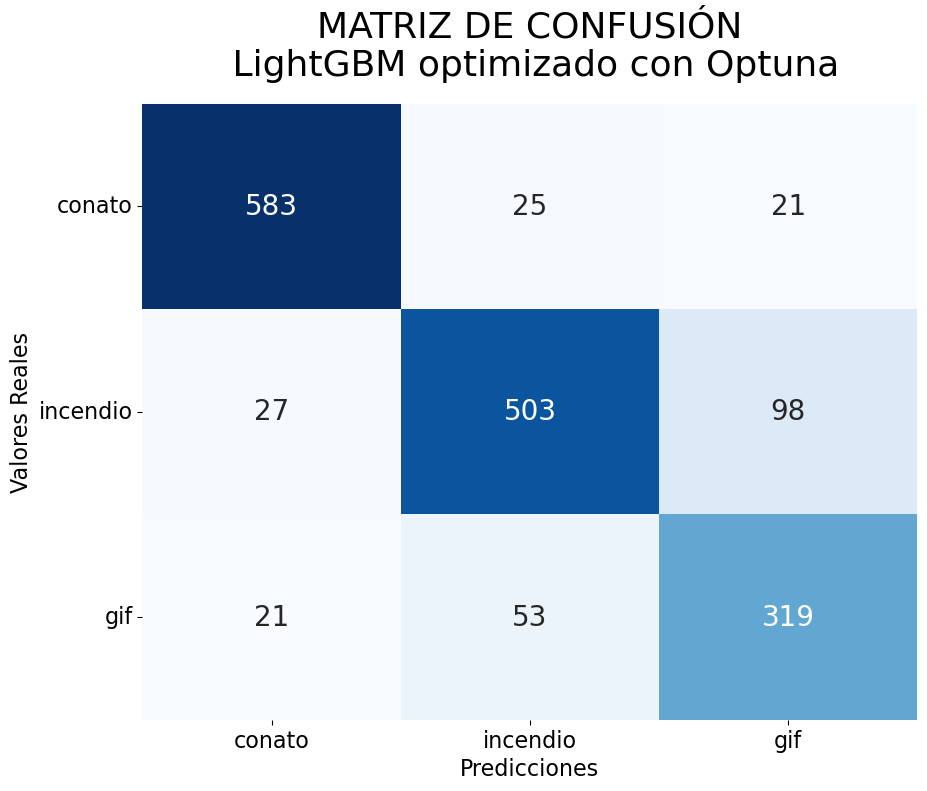

In [22]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Etiquetas de las clases
etiquetas = ['conato', 'incendio', 'gif']

plt.figure(figsize=(10, 8))

# Creamos y mostramos la matriz
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=etiquetas, yticklabels=etiquetas,
            annot_kws={"size": 20},cbar=False)

plt.title("MATRIZ DE CONFUSIÓN\n LightGBM optimizado con Optuna", fontsize=26, pad=20)
plt.xlabel("Predicciones", fontsize=16)
plt.ylabel("Valores Reales", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(rotation=0, fontsize=16)

# Mostramos la gráfica
plt.show()

In [23]:
import joblib
joblib.dump(best_model, 'best_lightGBM_model.pkl')

['best_lightGBM_model.pkl']

In [24]:
import joblib

# Cargar el modelo desde el archivo .pkl
best_model = joblib.load('best_lightGBM_model.pkl')

# Verificar si se cargó correctamente (opcional)
print("Modelo cargado correctamente:", best_model)

Modelo cargado correctamente: LGBMClassifier(colsample_bytree=0.9294851722869432,
               learning_rate=0.02184757982797271, max_depth=14,
               min_child_samples=52, num_leaves=222,
               subsample=0.8444314425151311)


@inproceedings{akiba2019optuna,
  title={{O}ptuna: A Next-Generation Hyperparameter Optimization Framework},
  author={Akiba, Takuya and Sano, Shotaro and Yanase, Toshihiko and Ohta, Takeru and Koyama, Masanori},
  booktitle={The 25th ACM SIGKDD International Conference on Knowledge Discovery \& Data Mining},
  pages={2623--2631},
  year={2019}
}

#### Fuentes de datos:

1. **AEMET**: Los datos utilizados en este análisis provienen de la **Agencia Estatal de Meteorología (AEMET)**. Los datos están sujetos a las [condiciones de uso de AEMET](https://www.aemet.es/es/portada), y deben ser utilizados con la debida citación.
2. **EGIF**: Los datos utilizados en este análisis provienen de la **Estadística General de Incendios Forestales (EGIF)**, gestionada por el **Ministerio para la Transición Ecológica y el Reto Demográfico (MITECO)**. Los datos deben ser utilizados de acuerdo con las [condiciones de uso de la EGIF](https://www.miteco.gob.es/es/biodiversidad/temas/incendios-forestales/estadisticas-datos.aspx).
3. **NGMEP (Nomenclátor Geográfico de Municipios y Entidades de Población)**: Los datos utilizados en este análisis provienen del **Nomenclátor Geográfico de Municipios y Entidades de Población (NGMEP)**, proporcionado por el **Centro Nacional de Información Geográfica (CNIG)**. Los datos están sujetos a la licencia de [Datos Abiertos del CNIG](https://astronoomia.ign.es/web/ign/portal). Se debe proporcionar citación adecuada al utilizar los datos.
4. **Climate Data Store (CDS)**: Los datos utilizados en este análisis provienen del **Climate Data Store (CDS)**, específicamente del indicador de peligro de incendio **FWI** derivado de proyecciones climáticas para Europa. Los datos están sujetos a la [licencia de uso de CDS](https://cds.climate.copernicus.eu/#!/home), y deben ser utilizados con la debida citación.
5. **INE (Instituto Nacional de Estadística)**: Los datos utilizados en este análisis provienen de las **Series de población por provincia (1900-2001)**, las **principales series de población desde 1998** y del **Código INE**. Los datos están sujetos a las [condiciones de uso del INE](https://www.ine.es/jaxiT3/Datos.htm?t=2865), y deben ser utilizados con la debida citación.